In [1]:
import pandas as pd
import numpy as np

from statsmodels.distributions.empirical_distribution import ECDF

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'
pio.renderers.default = 'png'
px.defaults.width = 1500
px.defaults.height = 500

# Data

In [2]:
ll = pd.read_csv('../data/data1.csv')
ll = ll.set_index('Date')

ll = -100*(np.log(ll)-np.log(ll.shift(1)))
ll = ll.iloc[1:]

ll = ll.rename_axis('Loss', axis=1)
ll.columns = [x[4:] for x in ll.columns]

# Framework Functions

In [3]:
def rv2_transform(x):
    y = np.log(1+np.exp(x))
    y = -1/np.log(y.rank()/(len(y)+1))
    y = np.sqrt(y)
    return y

In [4]:
def tail_mx(df):

    z = df.apply(rv2_transform, axis=0)

    r = z.apply(lambda x: np.linalg.norm(x,2), axis=1)
    w = z.div(r, axis=0)

    n   = len(r)
    r0  = np.quantile(r,0.95)
    nr0 = len(r[r>r0])
    m = (r0**2)*nr0/n

    S = (m/nr0) * w[r>r0].transpose().dot(w[r>r0])
    
    return S

In [5]:
def plot_mx(S):
    
    M = np.array(S.round(2))
    M[np.triu_indices(len(S),1)] = np.nan
    M = pd.DataFrame(M, index=S.index, columns=S.columns)

    fig = px.imshow(M, color_continuous_scale='Blues', text_auto=True, aspect='auto')
    
    fig.update_layout(xaxis_title='', yaxis_title='', width=700)
    
    return fig

In [6]:
def plot_loadings(u):
    
    fig = px.imshow(u.round(2), color_continuous_scale='RdBu', range_color=[-1,1], text_auto=True, aspect='auto')
    
    fig.update_layout(xaxis_title='', yaxis_title='', width=700)
    
    return fig

In [7]:
def plot_scores(v):
    
    fig = make_subplots(rows=3, cols=1)

    for i in range(3):
        fig.add_trace(
            go.Scatter(x=v.index, y=v.iloc[:,i]),
            row=i+1, col=1
        )
        fig.update_yaxes(title_text='v'+str(i+1), row=i+1, col=1)

    fig.update_layout(showlegend=False, height=1000, width=1500)
    
    return fig

In [8]:
def plot_scores_pairs(v):
    
    fig = make_subplots(rows=1, cols=3)

    for i in range(3):
        for j in range(i+1,3):
            fig.add_trace(
                go.Scatter(x=v.iloc[:,i], y=v.iloc[:,j], mode='markers'),
                row=1, col=i+j
            )
            fig.update_xaxes(title_text='v'+str(i+1), row=1, col=i+j)
            fig.update_yaxes(title_text='v'+str(j+1), row=1, col=i+j)

    a = v.iloc[:,:3].min().min()-1
    b = v.iloc[:,:3].max().max()+1
    fig.update_xaxes(range=(a,b), row=1, col=1)
    fig.update_yaxes(range=(a,b), row=1, col=1)
    fig.update_xaxes(range=(a,b), row=1, col=2)
    fig.update_yaxes(range=(a,b), row=1, col=2)
    fig.update_xaxes(range=(a,b), row=1, col=3)
    fig.update_yaxes(range=(a,b), row=1, col=3)

    fig.update_layout(showlegend=False, height=500, width=1500)

    return fig

# Tail Dependence Matrix
## Multivariate Estimation

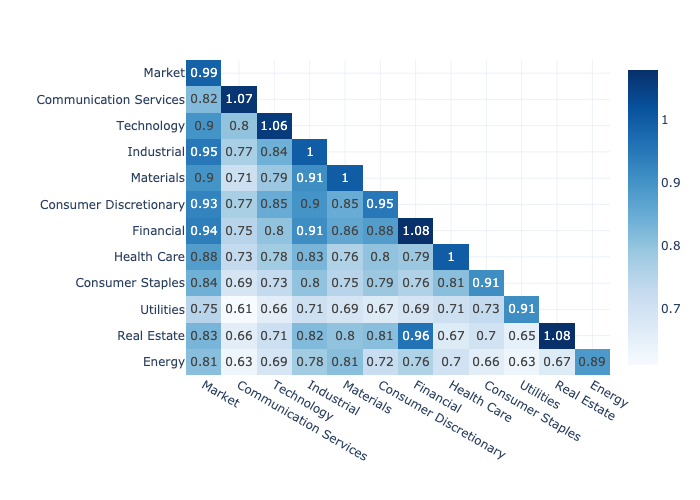

In [9]:
S = tail_mx(ll)

fig = plot_mx(S)
fig.write_image('../figures/tail_matrix.jpeg', scale=2)
fig.show()

## Pair By Pair Estimation
### Original Diagonal

In [10]:
S = []
for i in range(12):
    row = []
    for j in range(12):
        s = tail_mx(ll.iloc[:,[i,j]])
        row.append(s.iloc[0,1])
    S.append(row)
    
S = pd.DataFrame(S, index=ll.columns, columns=ll.columns)

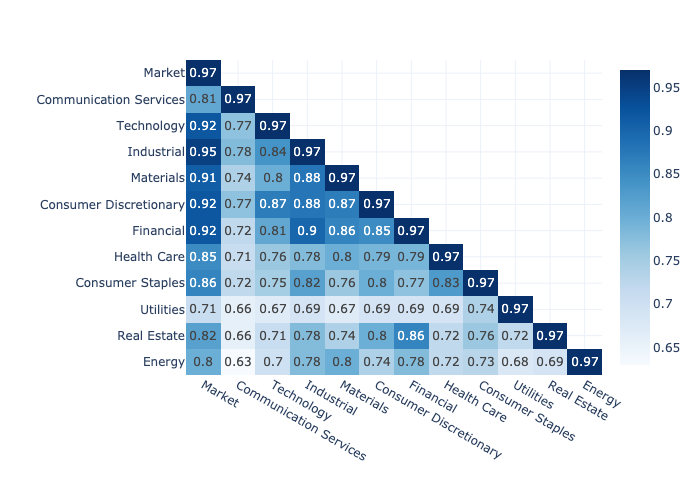

In [11]:
fig = plot_mx(S)
#fig.write_image('../figures/tail_matrix.jpeg', scale=2)
fig.show()

### Scaled Diagonal

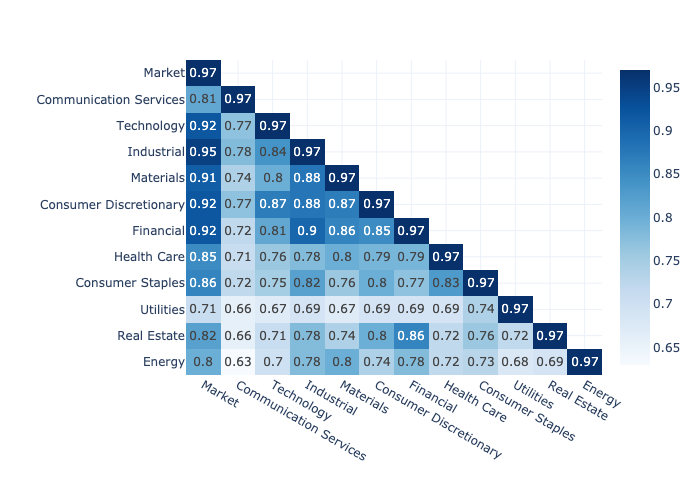

In [12]:
S_pairs = S/S.iloc[0,0]

fig = plot_mx(S)
#fig.write_image('../figures/tail_matrix.jpeg', scale=2)
fig.show()

In [13]:
tail_mx(ll.iloc[:,[0,1]])

,Market,Communication Services
Market,1.005942,0.814667
Communication Services,0.814667,0.973849


In [14]:
tail_mx(ll.iloc[:,[0,10]])

,Market,Real Estate
Market,1.010936,0.817704
Real Estate,0.817704,1.011199


In [15]:
tail_mx(ll.iloc[:,[0,0]])

,Market,Market
Market,0.974506,0.974506
Market,0.974506,0.974506


# Eigen Decomposition

## Version 1

In [16]:
S = tail_mx(ll)

e,u = np.linalg.eig(S)
e = e[:5]
u = pd.DataFrame(u[:,:5], index=ll.columns, columns=['u'+str(i) for i in range(1,6)])

v = ll.applymap(lambda x: max(x,0)).dot(u)
v.columns = ['v'+str(i) for i in range(1,6)]

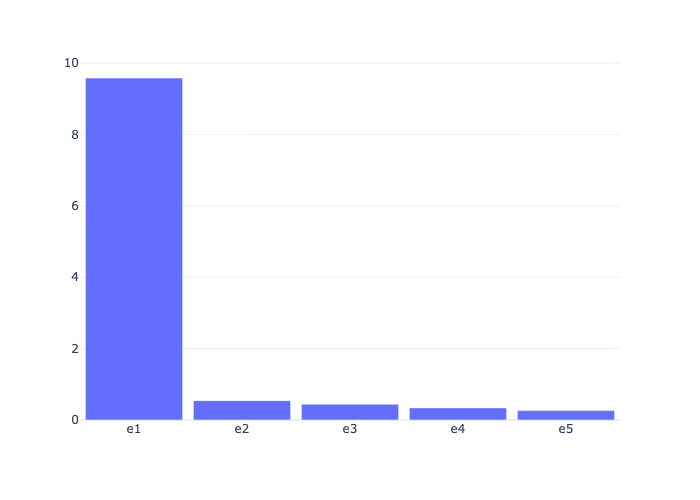

In [17]:
px.bar(x=['e'+str(i) for i in range(1,6)], y=e).update_layout(
    xaxis_title='', yaxis_title='', bargap=0.1, width=700
)

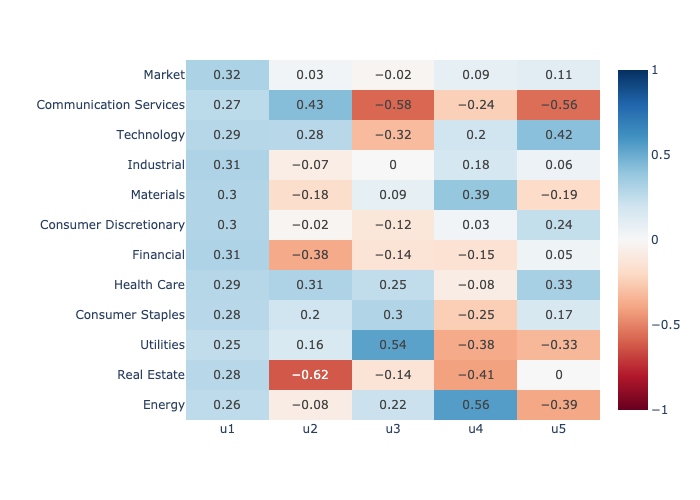

In [18]:
fig = plot_loadings(u)
fig.write_image('../figures/tail_loadings.jpeg', scale=2)
fig.show()

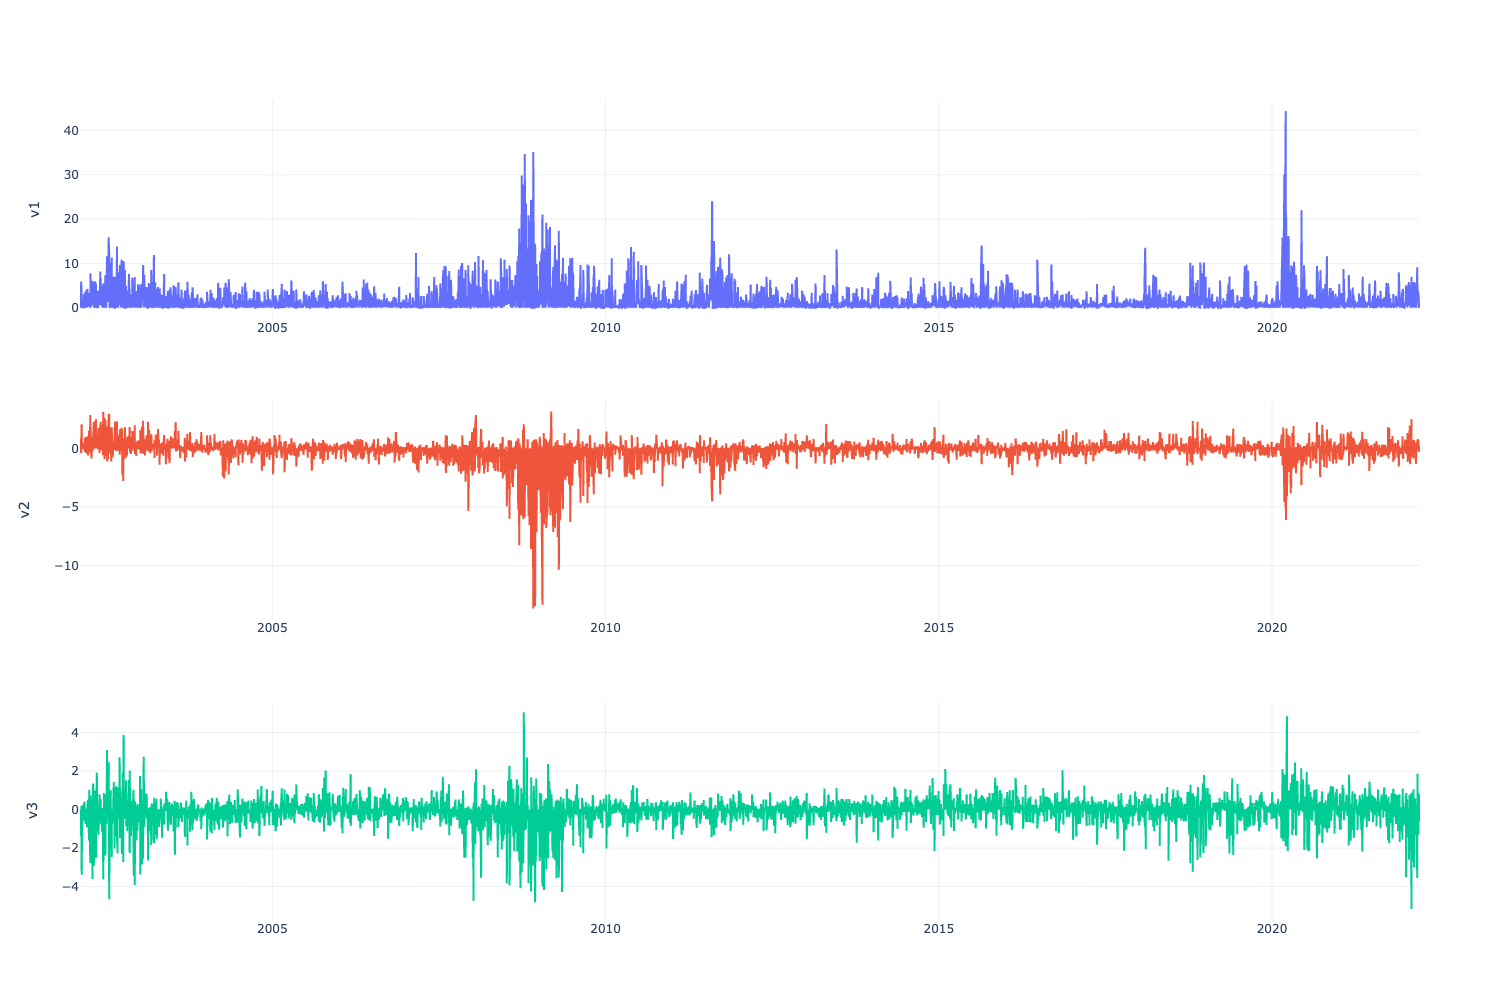

In [19]:
fig = plot_scores(v)
fig.write_image('../figures/tail_scores.jpeg', scale=2)
fig.show()

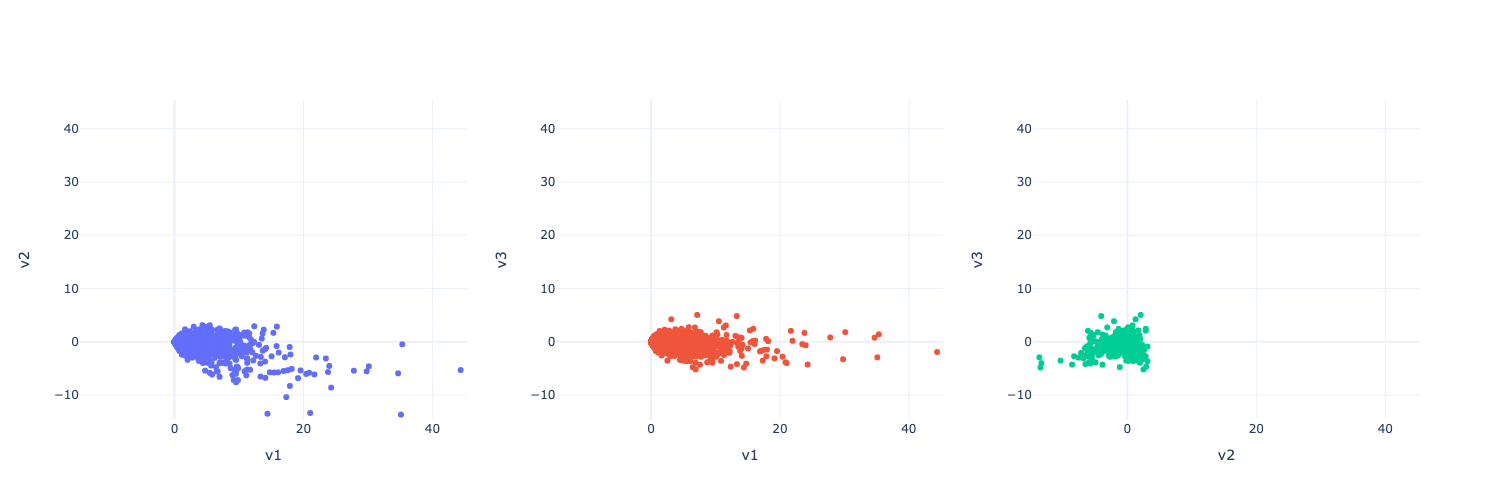

In [20]:
fig = plot_scores_pairs(v)
fig.write_image('../figures/tail_scores_scatter.jpeg', scale=2)
fig.show()

## Version 2

In [21]:
e,u = np.linalg.eig(S_pairs)
e = e[:5]
u = pd.DataFrame(u[:,:5], index=ll.columns, columns=['u'+str(i) for i in range(1,6)])

v = ll.applymap(lambda x: max(x,0)).dot(u)
v.columns = ['v'+str(i) for i in range(1,6)]

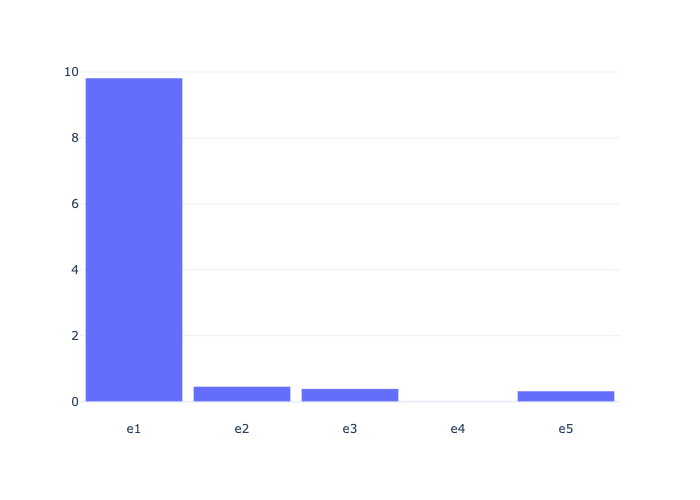

In [22]:
px.bar(x=['e'+str(i) for i in range(1,6)], y=e).update_layout(
    xaxis_title='', yaxis_title='', bargap=0.1, width=700
)

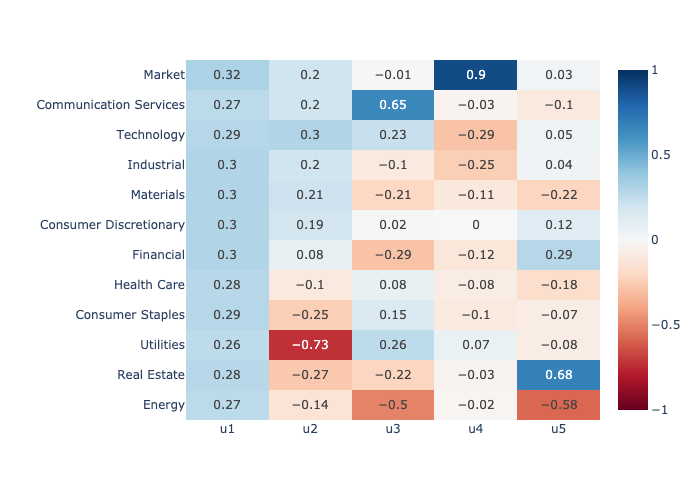

In [23]:
fig = plot_loadings(u)
#fig.write_image('../figures/tail_loadings.jpeg', scale=2)
fig.show()

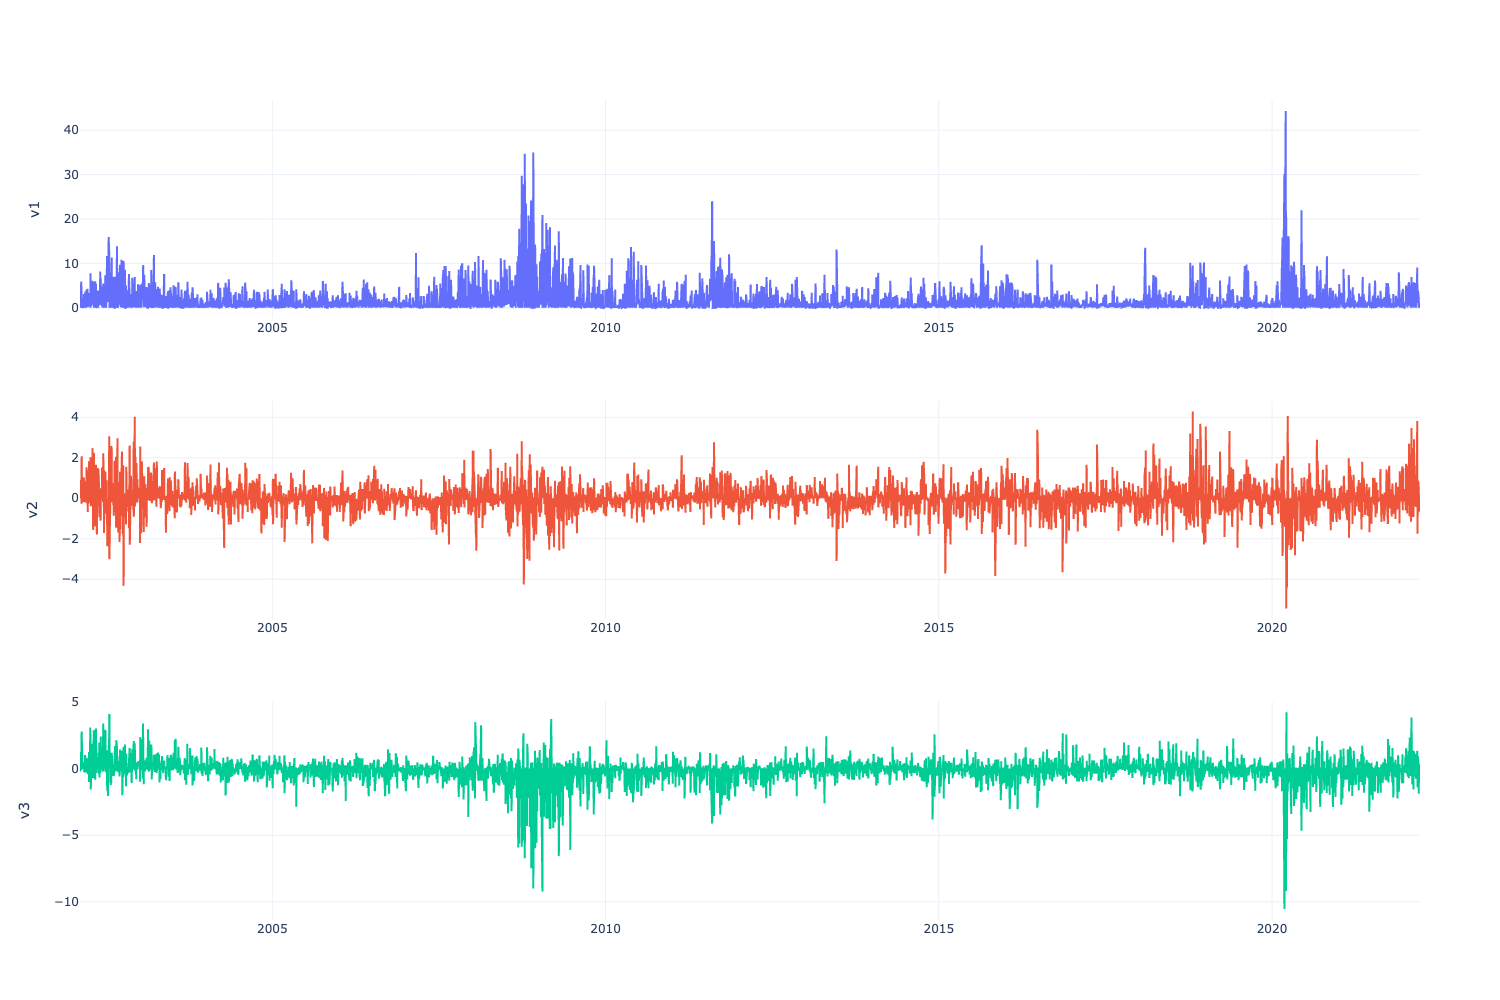

In [24]:
fig = plot_scores(v)
#fig.write_image('../figures/tail_scores.jpeg', scale=2)
fig.show()

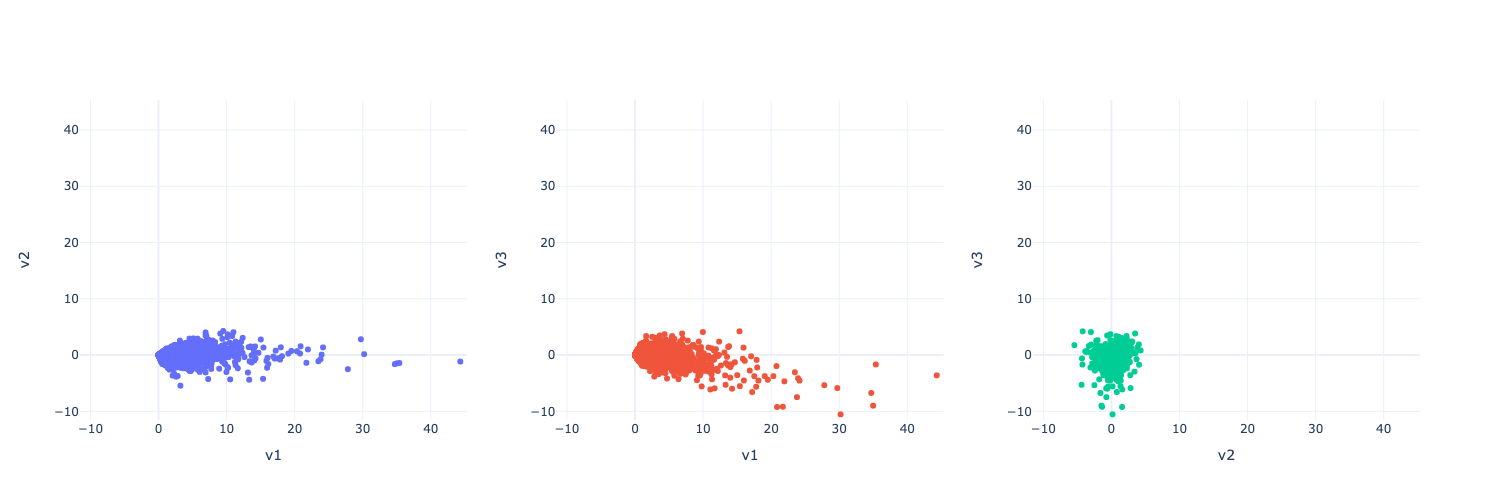

In [25]:
fig = plot_scores_pairs(v)
#fig.write_image('../figures/tail_scores_scatter.jpeg', scale=2)
fig.show()

## Sectors Only - No Market

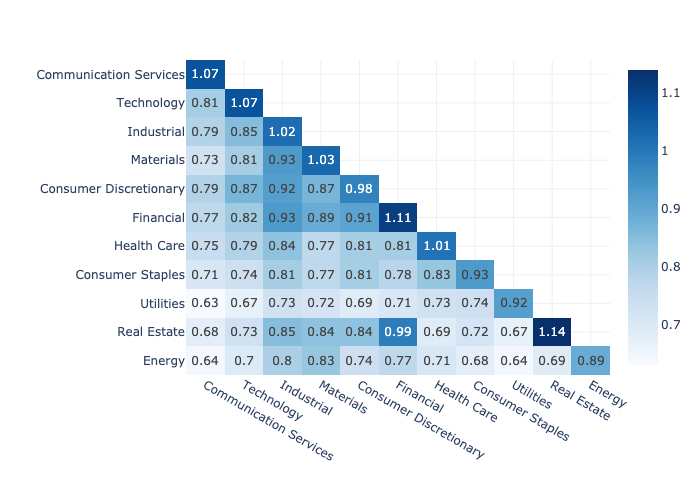

In [26]:
S = tail_mx(ll.iloc[:,1:])

fig = plot_mx(S)
fig.write_image('../figures/tail_matrix_nom.jpeg', scale=2)
fig.show()

In [27]:
e,u = np.linalg.eig(S)
e = e[:5]
u = pd.DataFrame(u[:,:5], index=ll.columns[1:], columns=['u'+str(i) for i in range(1,6)])
u.iloc[:,0] *= -1

v = ll.iloc[:,1:].applymap(lambda x: max(x,0)).dot(u)
v.columns = ['v'+str(i) for i in range(1,6)]

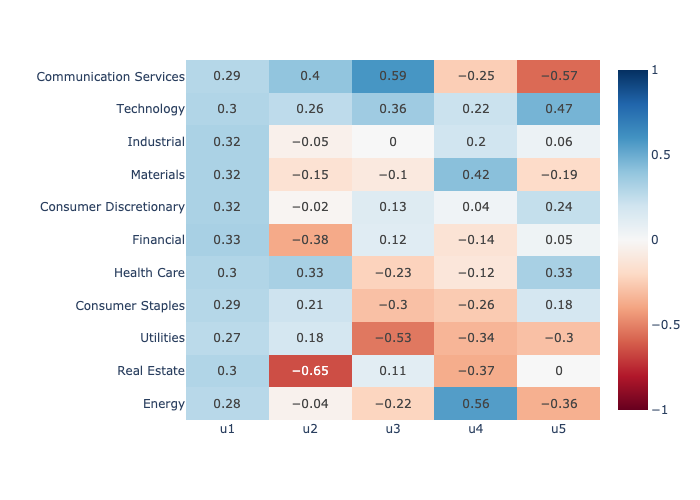

In [28]:
fig = plot_loadings(u)
fig.write_image('../figures/tail_loadings_nom.jpeg', scale=2)
fig.show()

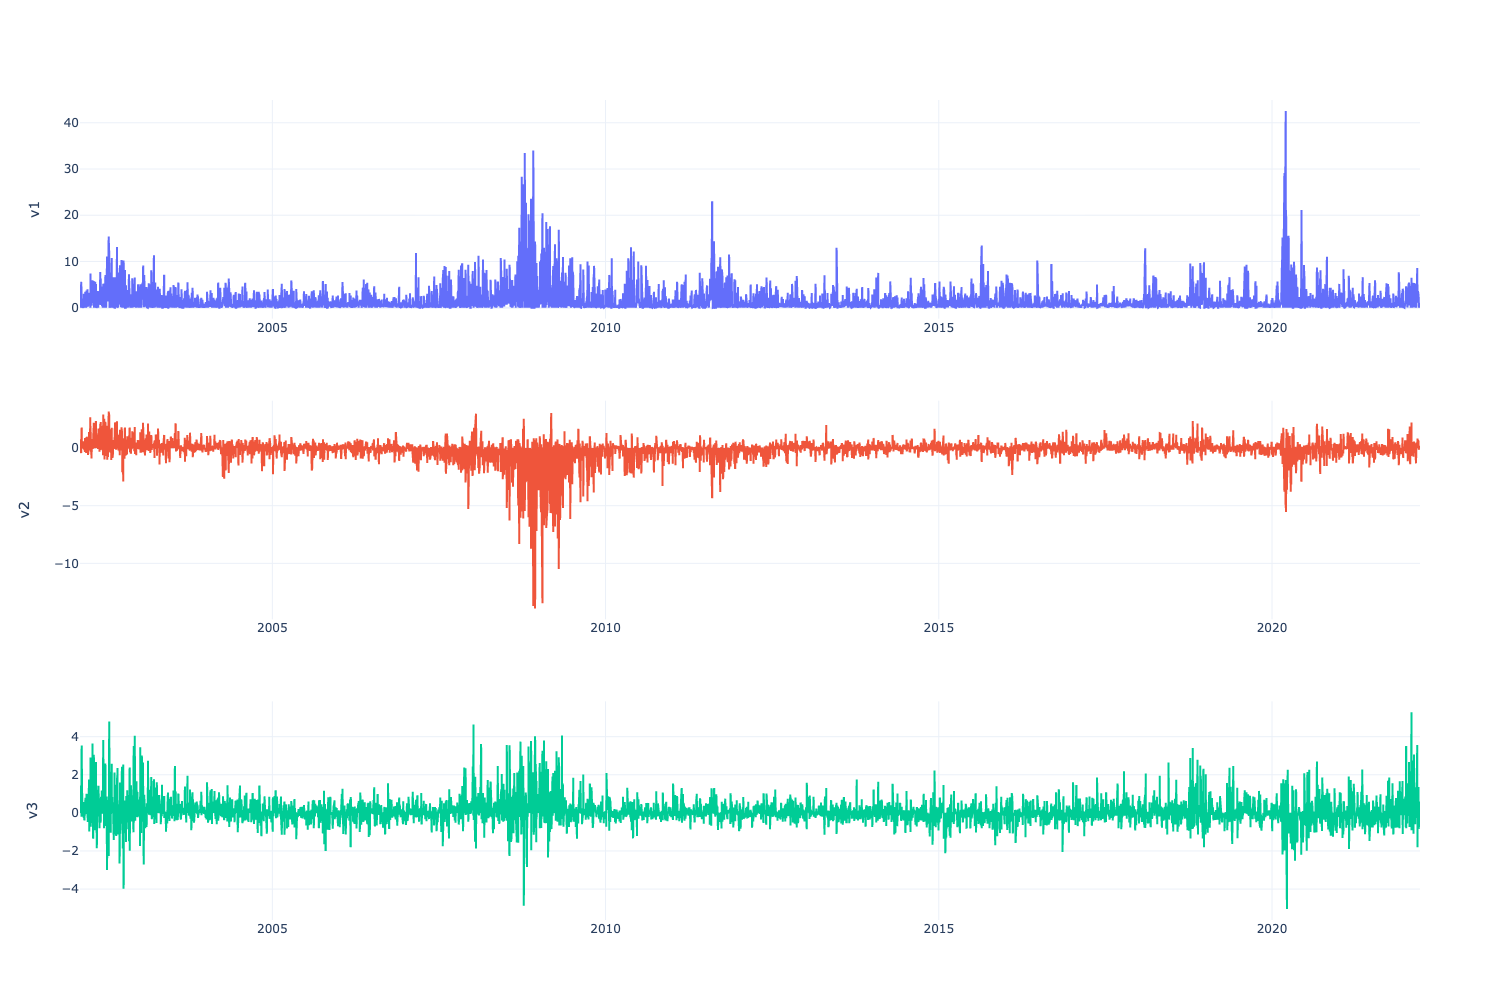

In [29]:
fig = plot_scores(v)
#fig.write_image('../figures/tail_scores_nom.jpeg', scale=2)
fig.show()

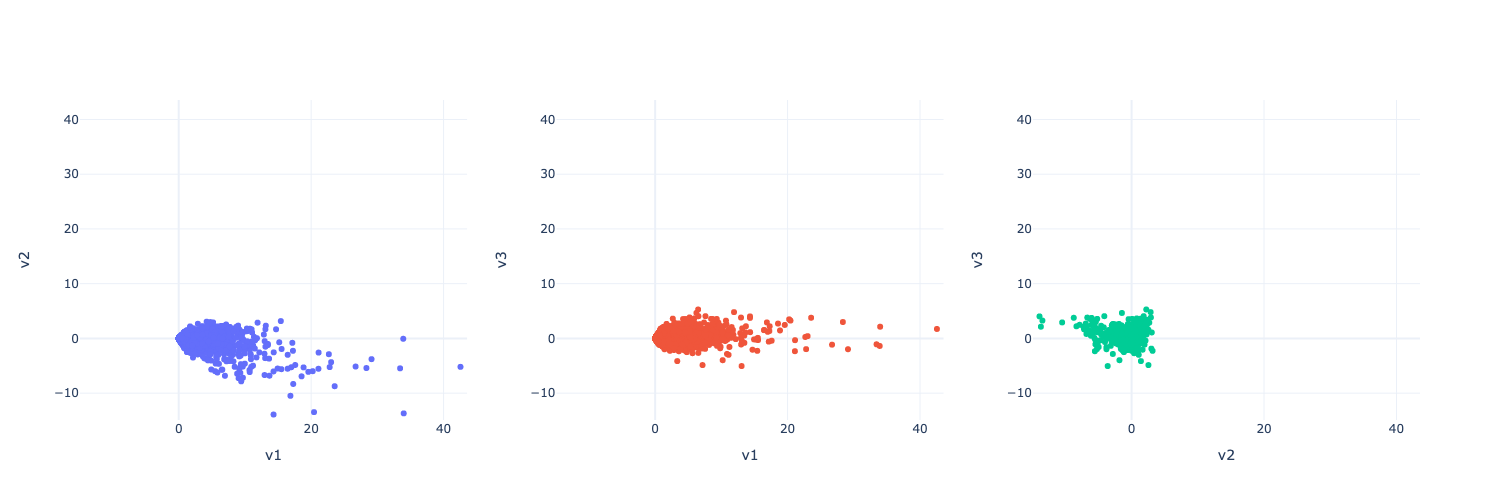

In [30]:
fig = plot_scores_pairs(v)
#fig.write_image('../figures/tail_scores_scatter_nom.jpeg', scale=2)
fig.show()

# Graph
## Partial Correlation

In [31]:
def part_corr(S):
    
    D = np.linalg.pinv(S.values)
    D = pd.DataFrame(D, index=S.index, columns=S.columns)

    d = pd.DataFrame(np.diag(np.diag(D)**(-1/2)), index=S.index, columns=S.columns)

    G = -d.dot(D).dot(d)

    for i in range(len(G)):
        G.iloc[i,i] = 0
    
    return G

In [32]:
def plot_g(G,u=0):
    
    M = np.array(G.applymap(lambda x: 0 if np.abs(x)<u else x).round(2))
    M[np.triu_indices(len(S),1)] = np.nan
    M = pd.DataFrame(M, index=G.columns, columns=G.columns)

    fig = px.imshow(M, color_continuous_scale='RdBu', range_color=[-1,1], text_auto=True, aspect='auto')
    fig.update_layout(xaxis_title='', yaxis_title='', width=700)
    
    return fig

In [33]:
S = tail_mx(ll.iloc[:,1:])
G = part_corr(S)

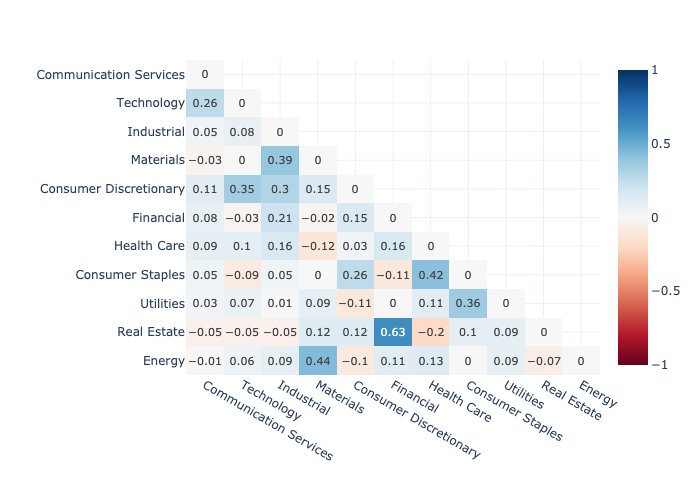

In [34]:
fig = plot_g(G)
#fig.write_image('../figures/graph_mx.jpeg', scale=2)
fig.show()

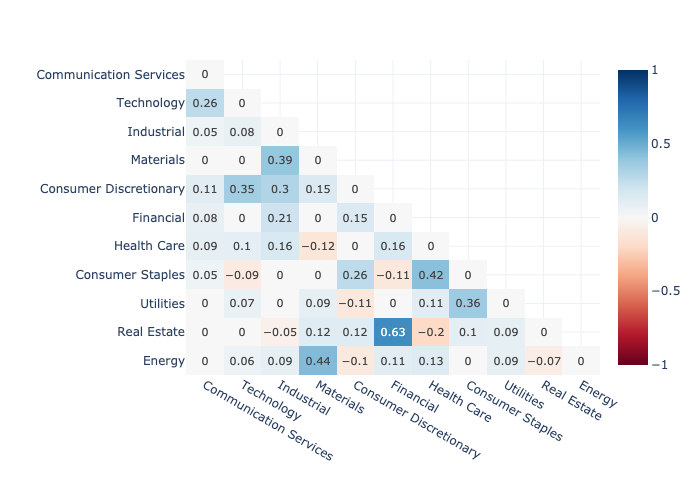

In [35]:
fig = plot_g(G,0.05)
#fig.write_image('../figures/graph_mx.jpeg', scale=2)
fig.show()

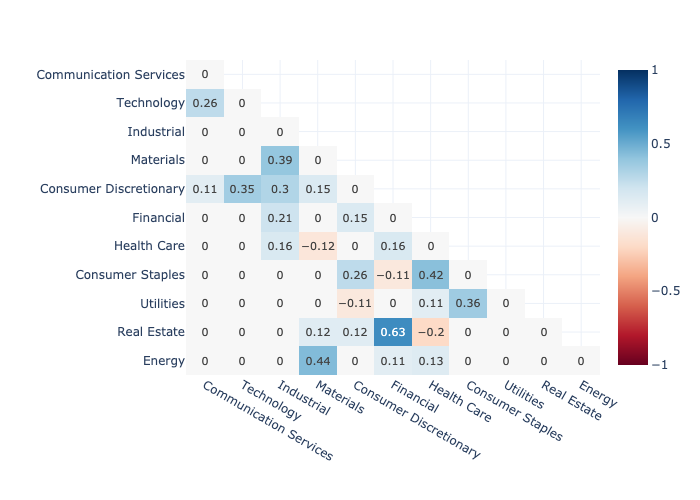

In [36]:
fig = plot_g(G,0.1)
#fig.write_image('../figures/graph_mx.jpeg', scale=2)
fig.show()

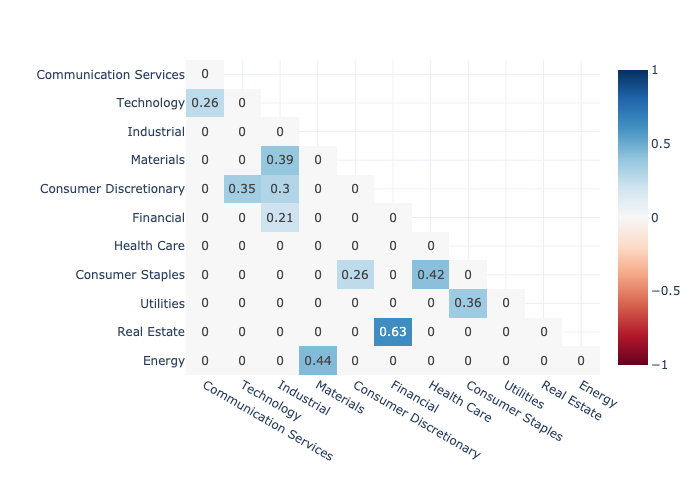

In [37]:
fig = plot_g(G,0.2)
#fig.write_image('../figures/graph_mx.jpeg', scale=2)
fig.show()

## Graphical Lasso CV

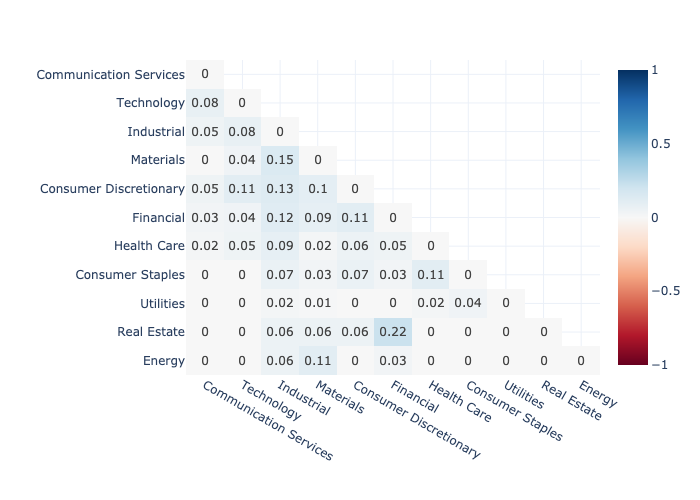

In [38]:
from sklearn.covariance import graphical_lasso

cov, prec = graphical_lasso(emp_cov=np.array(S), alpha=0.7)
cov = pd.DataFrame(cov, index=S.index, columns=S.columns)
prec = pd.DataFrame(prec, index=S.index, columns=S.columns)

G_glasso = part_corr(cov)
plot_g(G_glasso)